In [1]:
library(anndata)
library(Signac)
library(Seurat)
library(anndata)
library(ggplot2)
library(tidyverse)
library(Signac)
library(Seurat)
#library(EnsDb.Mmusculus.v102)
library(BSgenome.Mmusculus.UCSC.mm10)
#library(pastecs)
library(stringr)

Attaching SeuratObject

Attaching sp

── Attaching packages ───────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1
✔ purrr   0.3.4     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()   masks stats::filter()
✖ dplyr::lag()      masks stats::lag()
✖ readr::read_csv() masks anndata::read_csv()
✖ purrr::reduce()   masks Signac::reduce()
Lade nötiges Paket: BSgenome

Lade nötiges Paket: BiocGenerics


Attache Paket: ‘BiocGenerics’


Die folgenden Objekte sind maskiert von ‘package:dplyr’:

    combine, intersect, setdiff, union


Die folgenden Objekte sind maskiert von ‘package:stats’:

    IQR, mad, sd, var, xtabs


Die folgenden Objekte sind maskiert von ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, append,
    as.data

In [2]:
seurat <- readRDS("/Users/dominik.klein/data/seurat_new_annotations.rds")

In [3]:
delta_markers <- c("Hhex",
"Fchsd1",
"Sla2",
"Plac8",
"Slc2a3",
"Gm2109",
"Cer1",
"Cacna1h",
"Dpysl3",
"Masp1",
"Nrsn1",
"Glis1",
"Ptpro",
"Kctd8",
"Lingo1",
"Spock3",
"Kcnc2",
"Dscam",
"Bmp3",
"Ptprz1",
"Cfap61",
"Luzp2",
"Shisal2b",
"Mapk10",
"Gap43",
"Ngb",
"Egr3",
"Stxbp5l",
"Mef2c",
"Ppp1r17",
"Cbln4",
"Ly6h",
"F5",
"Dpp6",
"Cfap61",
"Syt1",
"Nptx2",
"Rgs9",
"Cidea",
"Unc5c",
"Sst")

In [4]:
seurat <- LinkPeaks(
  object = seurat,
  peak.assay = "ATAC_merged",
  expression.assay = "RNA",
  genes.use = delta_markers
)

Testing 39 genes and 228257 peaks



In [9]:
get_link_ranges <- function(object, assay, gene, n_links=0, upstream=0.05, downstream=0.05, smooth.spline.spar=0.65){
  # Gets the entire range of the n_links top peak-gene links of a given gene and the gene itself
  # object = seurat object
  # assay = ATAC/Peaks assay with links and annotation
  # gene = Gene for which links should be found
  # n_links = number of links to be included. If 0, estimate number of top links.
  # upstream/downstream = number of bases to add up/downstream. If < 1: defines the fraction of the total length that is added.
  
  # TO DO: score cut-off (abs scores)
  #detach("package:MOFA2", unload = TRUE)
  # get links for gene
  links_df <- as.data.frame(object[[assay]]@links[object[[assay]]@links$gene==gene])
  if (dim(links_df)[1] == 0){
      print("No links detected for this gene")
      return(list(c(0, 0)))
      }
  n_links <- nrow(links_df)
  links_df$abs_score <- abs(links_df$score)
  links_df <- links_df[order(links_df$abs_score, decreasing = TRUE),]
  links_df$rank <- seq(1,nrow(links_df))
  
  if (n_links == 0){
    # estimate top links
    model <- smooth.spline(x = links_df$rank, y = links_df$abs_score, spar = smooth.spline.spar, tol=1e-1)
    n_links <- which.max(stats::predict(model,  deriv = 2)$y)
  } 
  # get gene ranges
  gene_ranges <- data.frame(object[[assay]]@annotation@ranges[which(object[[assay]]@annotation$gene_name==gene)])[,c("start","end")]
  
  # get link ranges
  link_ranges <- links_df[1:n_links,c("start","end")]
  
  # get merge ranges
  ranges <- rbind(gene_ranges, link_ranges)
  chr <- links_df$seqnames[1]
  start <- min(ranges$start)
  end <- max(ranges$end)
  
  # add up/downstream ranges
  width <- end - start
  
  if (downstream < 1){
    downstream <- as.integer(width*downstream)
  }
  
  if (upstream < 1){
    upstream <- as.integer(width*upstream)
  }
  
  start <- start - upstream
  end <- end + downstream
  
  #plot link scores
  print(ggplot(links_df, aes(x=rank, y=abs_score)) + geom_point(color="firebrick") + geom_vline(xintercept = n_links, linetype=2) + labs(x="Rank", y="Absolute Score", title=paste0("Top Links (",n_links,")")))
  
  # return
  final_range <- GenomicRanges::GRanges(seqnames = chr, ranges = IRanges(start, end))
  final_range$gene <- gene
  return(list(final_range, links_df))
  # return(list("chr"=chr, 
  #                   "start"=start,
  #                   "end"=end,
  #                   "gene"=gene))
}

In [10]:
get_results <- function(object, ident, gene, n_links=3, downstream=0.2, assay="ATAC_merged"){
    Idents(object) <- seurat@meta.data[[ident]]
    res <- get_link_ranges(object = object, assay = assay, gene = gene, n_links = n_links, downstream = downstream)
    n_links <- nrow(res[[2]])
    range <- res[[1]]
    coverage <- CoveragePlot(
      object = seurat,
      region = range,
      features = range$gene,
      expression.assay = "RNA",
      annotation = FALSE,
      peaks = FALSE,
      links = FALSE
    )
    
    anno <- AnnotationPlot(object = seurat, region = range)

    #peaks <- PeakPlot(object = seurat, region = range, group.by = "count") + scale_color_gradient("Counts", low = "gray85", high = "black")
    peaks <- PeakPlot(object = seurat, region = range, color = "black") 

    links <- LinkPlot(object = seurat, region = range)  + scale_color_gradient2(low = "#d8002d", mid = "gray95",high = "#0075d7", midpoint = 0)#+ scale_color_viridis_c("Score",option = "mako", begin = 0.25, end = 1, direction = -1) #

    expression <- ExpressionPlot(
      object = seurat,
      features = range$gene,
      assay = "RNA"
    )

    combined <- CombineTracks(
      plotlist = list(coverage, anno, peaks, links),
      expression.plot = expression, 
      heights = c(8, 2, 1, 3),
      widths = c(18, 2)
    )

    print(combined)
    
    for (i in c(1:n_links)){
        feature <- res[[2]]$peak[i]
        counts <- as.vector(seurat[feature,][[assay]]@data)
        celltype <- seurat@meta.data[[ident]]
        data <- as_tibble(data.frame(counts, celltype))
        statistics <- data %>% group_by(celltype) %>% summarise(mean = mean(counts), n = n(), q25 = quantile(counts, 0.25), q50 = quantile(counts, 0.5), q75 = quantile(counts, 0.75))
        print(feature)
        print(statistics)

        #p <- ggplot(as_tibble(data), aes(factor(ident), counts)) + 
        #geom_violin() + 
        #geom_boxplot(width=.1) + 
        #labs(title = feature, x = "cluster", y = "normalized counts") + 
        #theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
        #print(p)
    }
    }

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 35 rows containing missing values (geom_segment).”


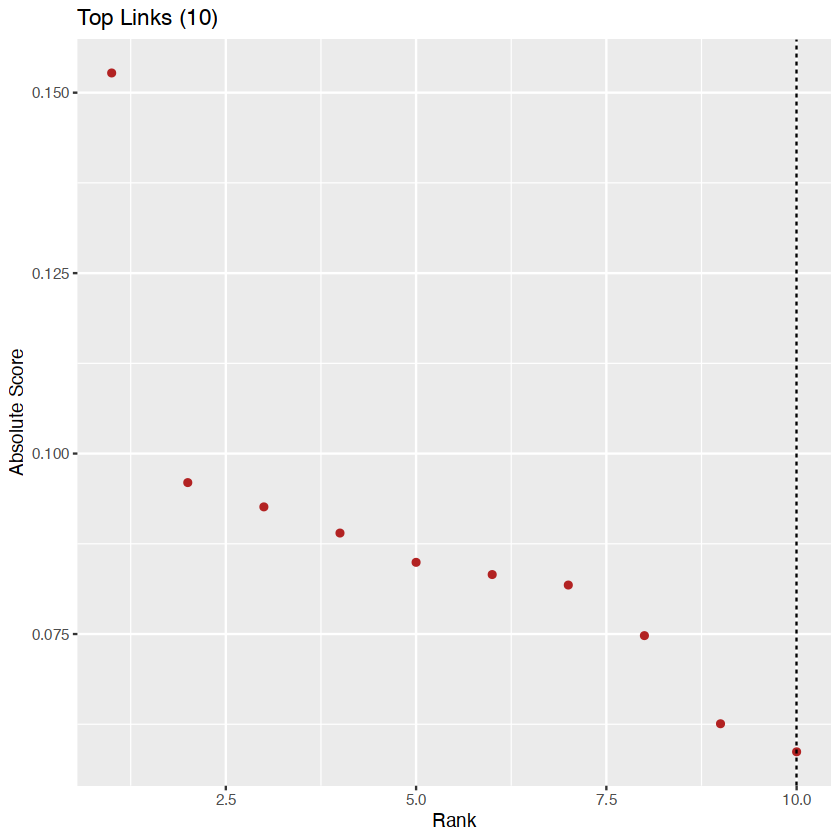

[1] "19-37442282-37443209"
# A tibble: 20 × 6
   celltype            mean     n   q25   q50   q75
   <chr>              <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.0487   460     0     0 0    
 2 Beta              0.0354   588     0     0 0    
 3 Delta             0.0785    77     0     0 0    
 4 Ductal            0.407   2906     0     0 0.814
 5 Eps. progenitors  0.0569   204     0     0 0    
 6 Epsilon           0.0579   247     0     0 0    
 7 Fev+              0.0798  1134     0     0 0    
 8 Fev+ Alpha        0.0705   433     0     0 0    
 9 Fev+ Beta         0.0649   833     0     0 0    
10 Fev+ Delta,0      0.0786    77     0     0 0    
11 Fev+ Delta,1      0.0233    56     0     0 0    
12 Fev+ Delta,2      0.0331    41     0     0 0    
13 Fev+ Delta,3      0          1     0     0 0    
14 Fev+ Delta,4      0          1     0     0 0    
15 Imm. Acinar       0.244   1928     0     0 0    
16 Mat. Acinar       0.131   1322     0     0 0    
17 Ngn3 high      

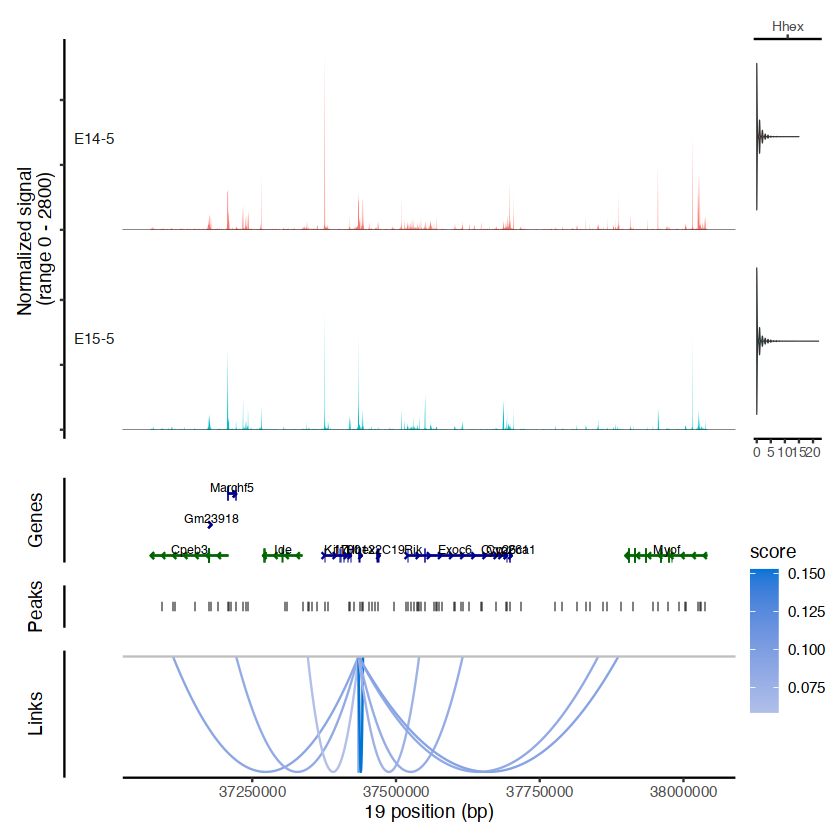

In [11]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[1]])

In [12]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[2]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [13]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[3]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [14]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[4]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[5]])

In [15]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[6]])

[1] "No links detected for this gene"


ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'x' bei der Methodenauswahl für Funktion 'nrow': Indizierung außerhalb der Grenzen


Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 71 rows containing missing values (geom_segment).”


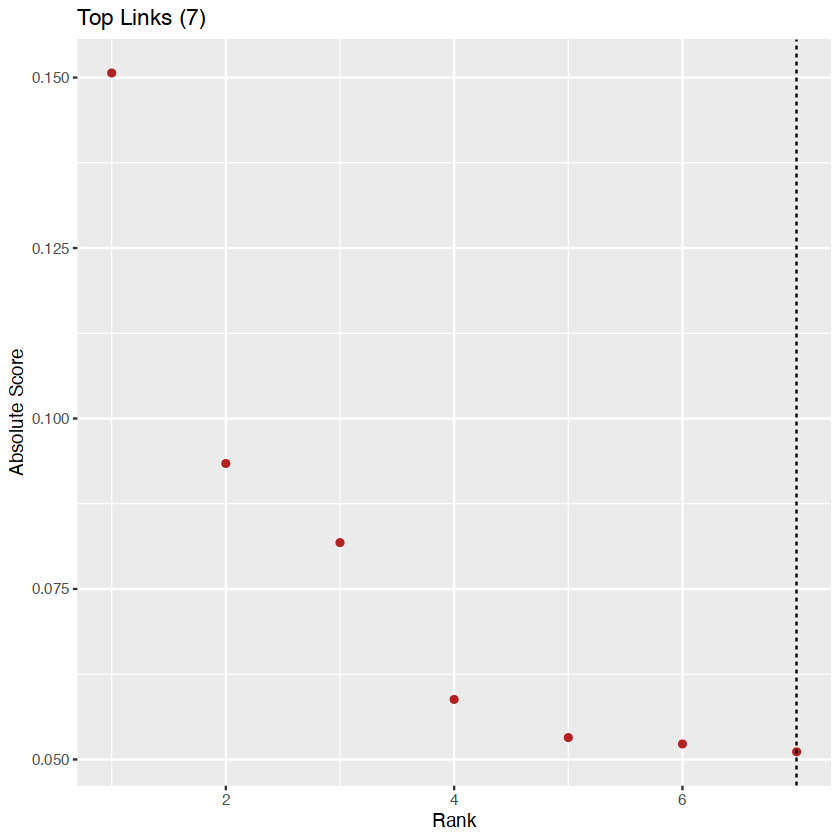

[1] "4-82884752-82885662"
# A tibble: 20 × 6
   celltype             mean     n   q25   q50   q75
   <chr>               <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.161     460  0    0     0    
 2 Beta              0.219     588  0    0     0    
 3 Delta             0.468      77  0    0     1.26 
 4 Ductal            0.0447   2906  0    0     0    
 5 Eps. progenitors  0.646     204  0    0     1.36 
 6 Epsilon           0.419     247  0    0     0.938
 7 Fev+              0.352    1134  0    0     0    
 8 Fev+ Alpha        0.176     433  0    0     0    
 9 Fev+ Beta         0.209     833  0    0     0    
10 Fev+ Delta,0      0.603      77  0    0     1.31 
11 Fev+ Delta,1      0.247      56  0    0     0    
12 Fev+ Delta,2      0.516      41  0    0     1.20 
13 Fev+ Delta,3      1.31        1  1.31 1.31  1.31 
14 Fev+ Delta,4      0           1  0    0     0    
15 Imm. Acinar       0.0350   1928  0    0     0    
16 Mat. Acinar       0.00911  1322  0    0     0    
1

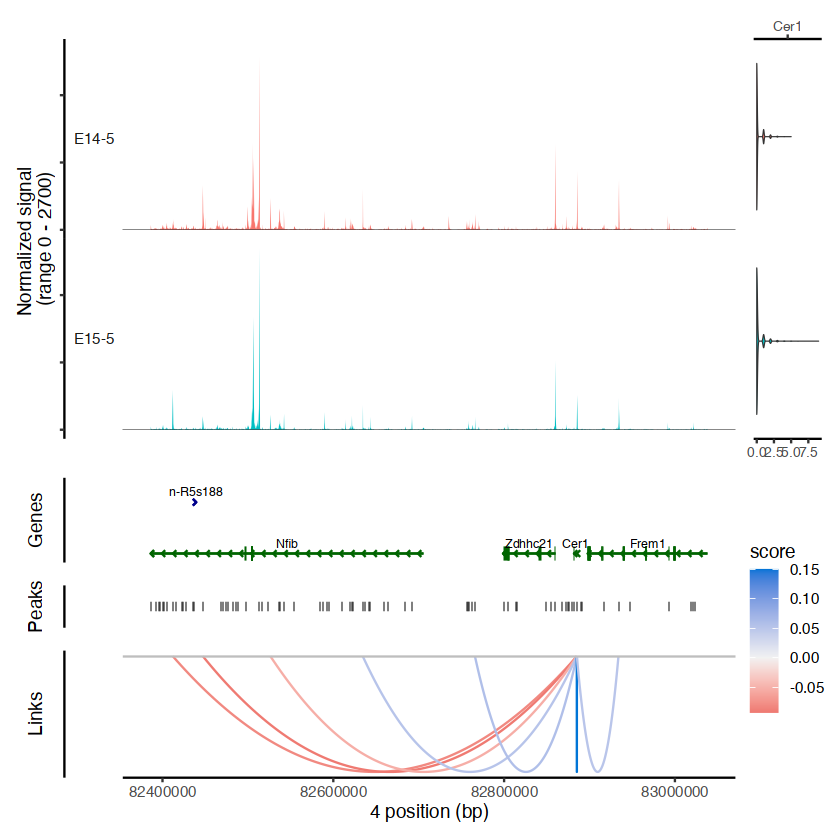

In [16]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[7]])

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.

Warning message:
“Removed 47 rows containing missing values (geom_segment).”


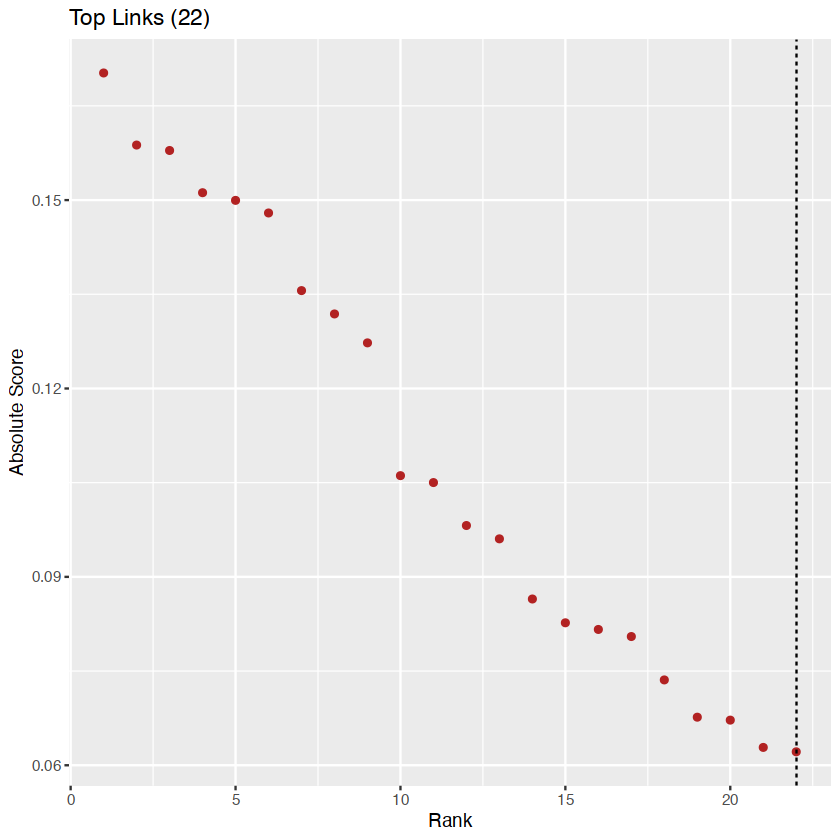

[1] "17-25802832-25803742"
# A tibble: 20 × 6
   celltype            mean     n   q25   q50   q75
   <chr>              <dbl> <int> <dbl> <dbl> <dbl>
 1 Alpha             0.512    460  0    0     1.14 
 2 Beta              0.474    588  0    0     1.18 
 3 Delta             0.467     77  0    0     1.26 
 4 Ductal            0.0773  2906  0    0     0    
 5 Eps. progenitors  0.594    204  0    0     1.27 
 6 Epsilon           0.666    247  0    0     1.32 
 7 Fev+              0.516   1134  0    0     1.06 
 8 Fev+ Alpha        0.568    433  0    0     1.22 
 9 Fev+ Beta         0.468    833  0    0     1.07 
10 Fev+ Delta,0      0.674     77  0    0.653 1.27 
11 Fev+ Delta,1      0.452     56  0    0     0.970
12 Fev+ Delta,2      0.425     41  0    0     0.924
13 Fev+ Delta,3      1.01       1  1.01 1.01  1.01 
14 Fev+ Delta,4      1.19       1  1.19 1.19  1.19 
15 Imm. Acinar       0.0598  1928  0    0     0    
16 Mat. Acinar       0.0199  1322  0    0     0    
17 Ngn3 high      

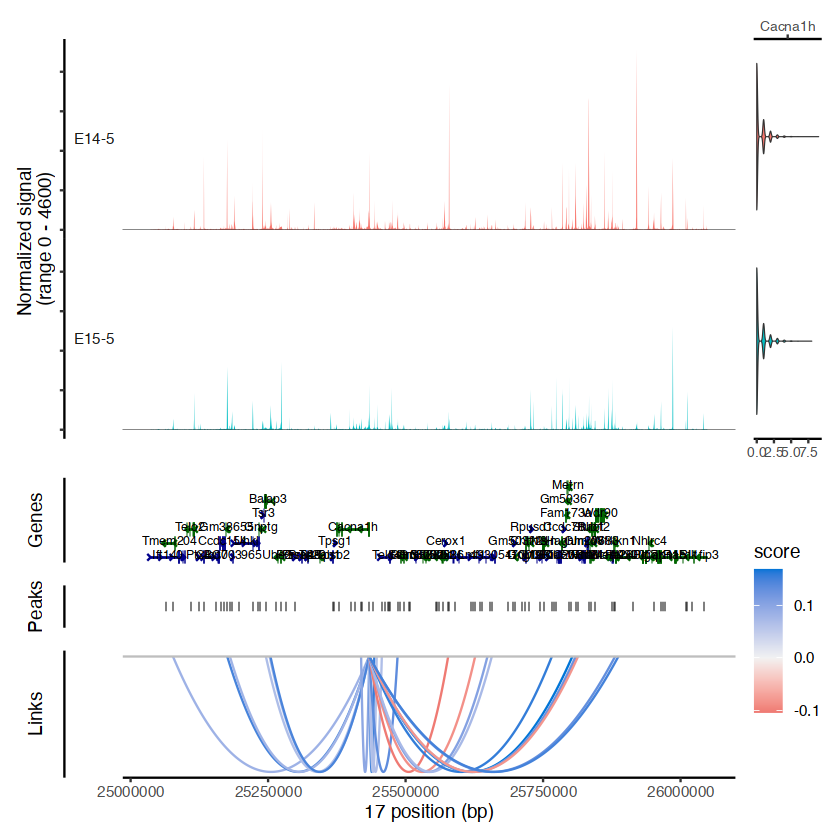

In [17]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[8]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[9]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[10]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[11]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[12]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[13]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[14]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[15]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[16]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[17]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[18]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[19]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[20]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[21]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[22]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[23]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[24]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[25]])

In [ ]:
get_results(seurat, "Fev_delta_refinement_gex", delta_markers[[26]])